### Установка библиотек

In [1]:
!pip install -q langchain langchain-openai langgraph tavily-python qdrant-client langchain-text-splitters langfuse


[notice] A new release of pip is available: 25.1.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### Импорты

In [ ]:
import os
from typing import TypedDict, List, Dict, Any, Optional, Literal

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

from tavily import TavilyClient

from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance, PointStruct

from langfuse import Langfuse, observe

import json
import uuid

from pprint import pprint
from google.colab import userdata

### Что будем делать сегодня?

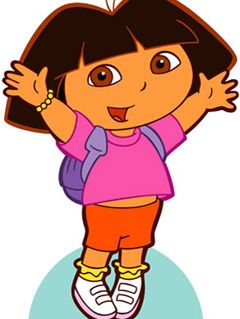

**Помощник по планированию путешествия**

*Агент* собирает информацию о достопримечательностях, погоде, организации путешествия и составляет оптимальный план путешествия

#### Что такое агент?

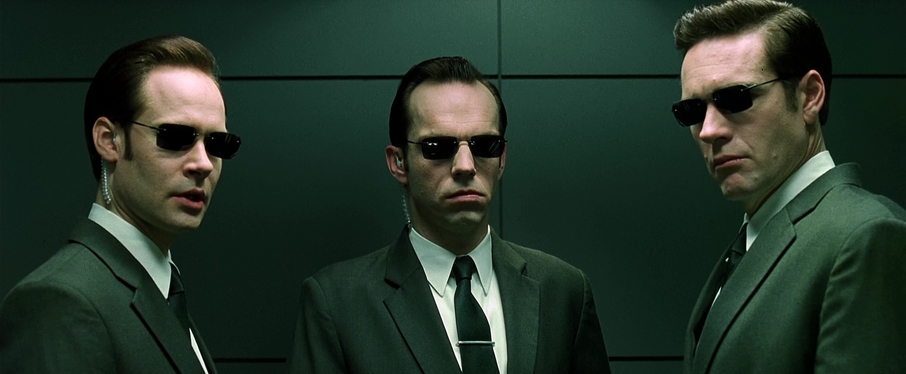

Агент в контексте LLM - это программная система, где LLM выступает «мозгом» и сама выбирает, какие шаги и действия выполнить, чтобы достичь цели, а не просто генерирует один ответ на запрос.

#### Отличие LLM от агента

**Обычный LLM (реактивный режим):**
- Получает один prompt → выдаёт один ответ.
- Не помнит цели, не планирует.
- Не умеет вызывать внешние инструменты самостоятельно.

**LLM-агент:**
- Понимает **цель пользователя**.
- **Планирует** последовательность шагов.
- **Вызывает инструменты** (web search, базы данных, API).
- **Анализирует промежуточные результаты** и решает, что делать дальше.
- Может работать в несколько итераций, пока не достигнет цели.


### Некоторые паттерны agent-систем

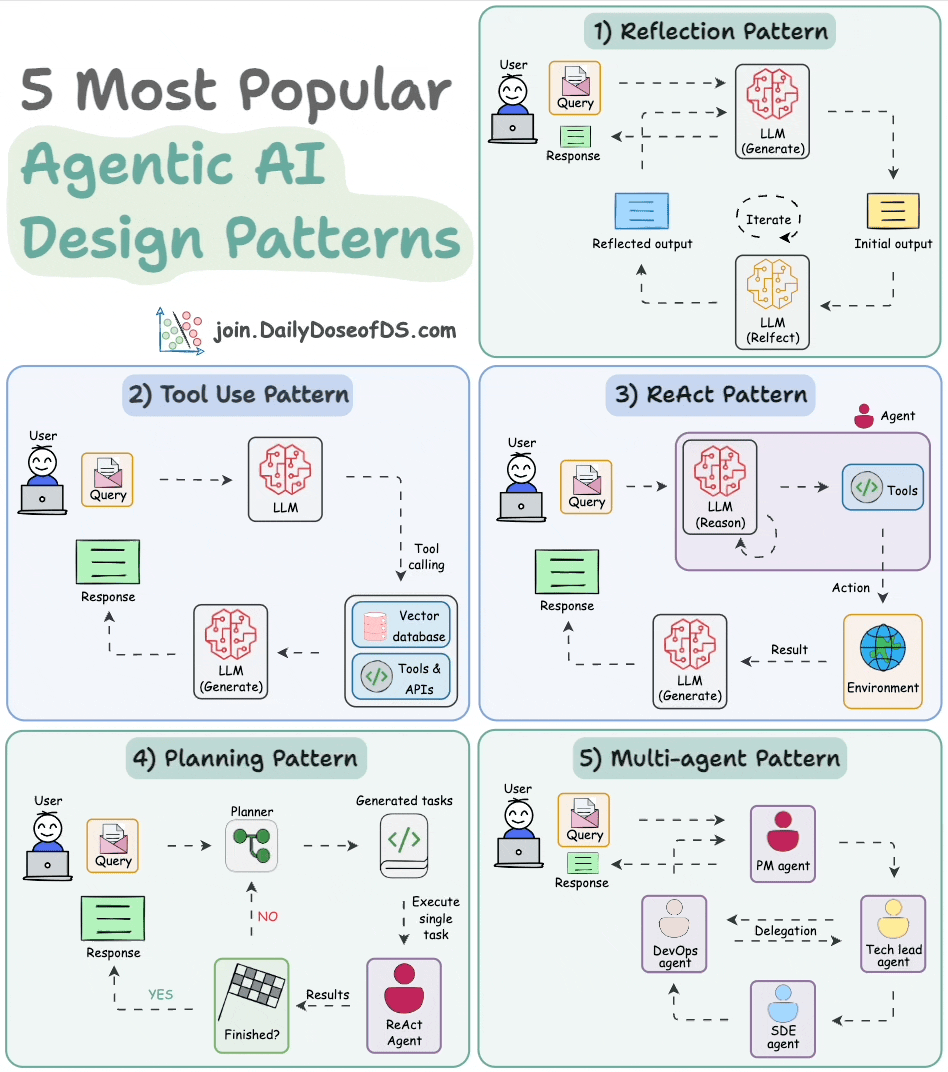

### Что нам понадобится?

- [LangGraph](https://www.langchain.com/langgraph) — фреймворк от команды LangChain для построения LLM‑приложений и агентов как графов состояний (узлы/рёбра), что удобно для ветвлений, циклов и управляемого workflow вместо линейных цепочек.


- [Langfuse](https://langfuse.com/) — open‑source платформа LLMOps для observability: трассировка вызовов, отладка, оценка качества и эксперименты/управление промптами в LLM‑приложениях.
​

- [Tavily](https://www.tavily.com/) — поисковый API/инструмент для LLM‑агентов, который подключают как web search для получения актуальной информации из интернета в ходе выполнения агента/RAG.
​

In [ ]:
QDRANT_COLLECTION = "districts_rag"
LLM_MODEL = "gpt-4o-mini"
EMBEDDING_MODEL = "text-embedding-3-small"

### Инициализация клиентов

In [ ]:
llm = ChatOpenAI(
    base_url="https://openai.api.proxyapi.ru/v1",
    api_key= userdata.get("PROXYAPI_KEY"),
    model=LLM_MODEL,
    temperature=0.2,
)

embeddings = OpenAIEmbeddings(
    base_url="https://openai.api.proxyapi.ru/v1",
    model=EMBEDDING_MODEL,
    api_key=userdata.get("PROXYAPI_KEY"),
)

tavily = TavilyClient(api_key=userdata.get("TAVILY_API_KEY"))

langfuse = Langfuse(
    public_key=userdata.get("LANGFUSE_PUBLIC_KEY"),
    secret_key=userdata.get("LANGFUSE_SECRET_KEY"),
    host=userdata.get("LANGFUSE_HOST"),
)

### Основные кирпичики LangGraph

LangGraph строится на четырёх фундаментальных концепциях:

- **Граф (Graph)** — это дорожная карта возможных путей выполнения логики.

- **Узлы (Nodes)** — это точки на карте, где происходит реальная работа. Каждый узел выполняет конкретную функцию: обращается к базе данных, вызывает API, принимает решение или просто обновляет информацию.

- **Рёбра (Edges)** — это дороги между точками. Они определяют, как и когда программа переходит от одного действия к другому. Рёбра бывают простые («всегда иди туда») и условные («иди туда, если выполнено условие»).

- **Состояние (State)** — это багаж, который путешествует вместе с процессом. В нём хранится вся необходимая информация: входные данные, промежуточные результаты, история действий.




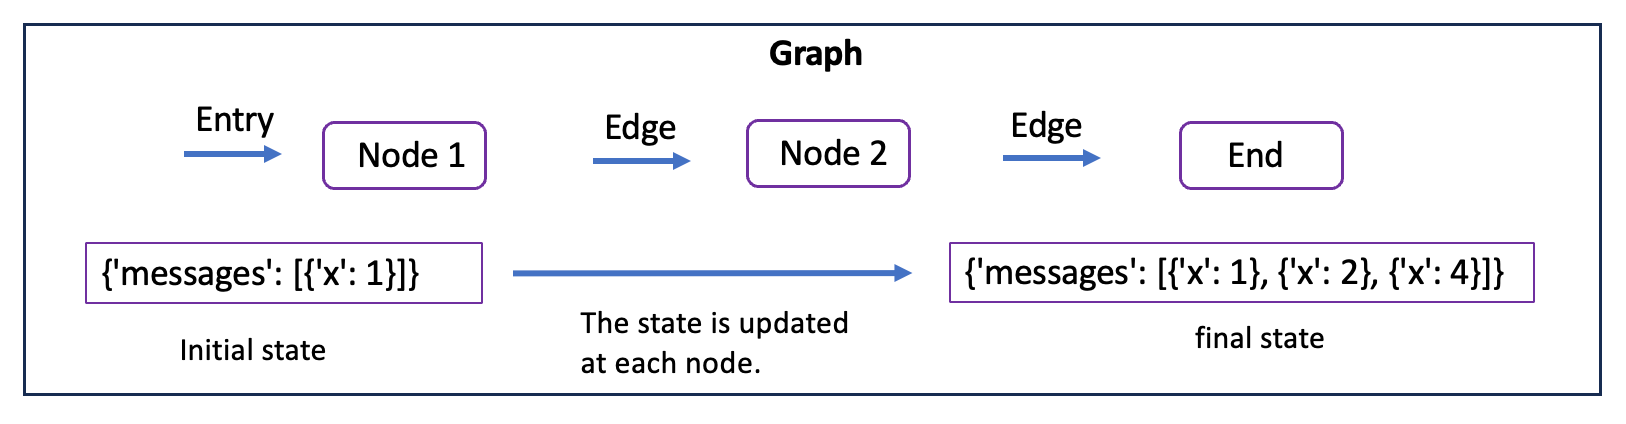

### Состояние

In [ ]:
class TravelState(TypedDict, total=False):
    messages: List[Dict[str, Any]]
    user_request: str

    # План (список подзадач)
    plan: List[str]
    facts: Dict[str, Any]

    # Результаты RAG и поиска
    rag_docs: List[Dict[str, Any]]
    citations: List[str]
    web_results: List[str]

    # Финальный маршрут
    itinerary: Dict[str, Any]

    # Допущения
    assumptions: List[str]

    # Для отладки и мониторинга
    debug_notes: List[str]

    # Внутреннее: статус ноды
    status: Literal["analyzing", "gathering", "answering", "done"]

    # Для маршрутизации rag/поиск
    need_rag: bool
    need_search: bool

    # Для уточнения
    refine_iterations: int
    refine_needed: bool
    refine_query: Optional[str]

### Веб-поиск

In [ ]:
@tool
def web_search(query: str) -> Dict[str, Any]:
    """
    Поиск через Tavily.
    Обязательно указывать:
    - query: конкретный вопрос (например, "visa requirements for Russian citizens to Spain in 2026")
    Возвращает:
    - "results": список {"title", "url", "content"}
    """
    res = tavily.search(query=query, max_results=5, country='russia', search_depth="advanced")
    return res

tools = [web_search]

### RAG с Qdrant: локальная база правил авиаперевозок

Подготовим данные

In [ ]:
with open('Avia_Rules.txt', 'r', encoding='utf-8') as f:
  rules = f.read()
rules[:3000]

'     I. Общие положения\n     \n     1. Федеральные авиационные правила «Общие правила воздушных перевозок пассажиров, багажа, грузов и требования к обслуживанию пассажиров, грузоотправителей, грузополучателей» (далее – Правила) разработаны в соответствии с Конвенцией для унификации некоторых правил, касающихся международных воздушных перевозок* (Варшава, 12 октября    1929 г.) и статьями 102 и 106 Федерального закона от 19 марта 1997 г. № 60-ФЗ «Воздушный кодекс Российской Федерации»** (далее - Воздушный кодекс Российской Федерации).\n     Правила определяют условия воздушной перевозки пассажиров, вещей пассажира, включая вещи, находящиеся при пассажире, и ручную кладь, перевозимых на борту воздушного судна на основании договора воздушной перевозки пассажира (далее - багаж), имущества, принятого к перевозке на основании грузовой накладной (далее – груз), права и обязанности перевозчика, других лиц, участвующих в организации и обеспечении воздушных перевозок, а также пассажиров, грузо

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, separators=['\n     ', '\n', ' '])
rules_chunks = text_splitter.split_text(rules)
rules_chunks[:5]

['I. Общие положения\n     \n     1. Федеральные авиационные правила «Общие правила воздушных перевозок пассажиров, багажа, грузов и требования к обслуживанию пассажиров, грузоотправителей, грузополучателей» (далее – Правила) разработаны в соответствии с Конвенцией для унификации некоторых правил, касающихся международных воздушных перевозок* (Варшава, 12 октября    1929 г.) и статьями 102 и 106 Федерального закона от 19 марта 1997 г. № 60-ФЗ «Воздушный кодекс Российской Федерации»** (далее - Воздушный кодекс Российской Федерации).',
 'Правила определяют условия воздушной перевозки пассажиров, вещей пассажира, включая вещи, находящиеся при пассажире, и ручную кладь, перевозимых на борту воздушного судна на основании договора воздушной перевозки пассажира (далее - багаж), имущества, принятого к перевозке на основании грузовой накладной (далее – груз), права и обязанности перевозчика, других лиц, участвующих в организации и обеспечении воздушных перевозок, а также пассажиров, грузоотправ

In [ ]:
len(rules_chunks)

132

Инициализируем Qdrant

In [ ]:
qdrant = QdrantClient(":memory:")  # in-memory для демонстрации
collection_name = "travel_rules"

In [ ]:
vector_size = len(embeddings.embed_query("test"))
vector_size

1536

Создаём коллекцию

In [ ]:
qdrant.recreate_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=vector_size, distance=Distance.COSINE),
)

/tmp/ipython-input-573818284.py:1: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant.recreate_collection(


True

Заливаем документы

In [ ]:
points = []
for idx, doc in enumerate(rules_chunks):
    vec = embeddings.embed_query(doc)
    points.append(
        PointStruct(
            id=idx,
            vector=vec,
            payload={"text": doc},
        )
    )

qdrant.upsert(collection_name=collection_name, points=points)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [ ]:
def rag_retrieve(query: str, top_k: int = 3) -> List[Dict[str, Any]]:
    vec = embeddings.embed_query(query)
    hits = qdrant.query_points(
        collection_name=collection_name,
        query=vec,
        limit=top_k
    )
    docs = []
    for h in hits.points:
        payload = h.payload
        docs.append(
            {
                "text": payload["text"],
                "category": payload.get("category"),
                "score": h.score,
            }
        )
    return docs

In [ ]:
rag_retrieve("Как летать с собакой-поводырем?")

[{'text': '113. Пассажир, лишенный зрения, по согласованию с перевозчиком может перевозиться в сопровождении собаки-поводыря. \n     Перевозка пассажира, лишенного зрения, в сопровождении собаки-поводыря может быть произведена при предъявлении перевозчику документа, подтверждающего инвалидность этого пассажира, и документа, подтверждающего специальное обучение собаки-поводыря.\n     Собака-поводырь, сопровождающая пассажира, лишенного зрения, перевозится бесплатно сверх установленной нормы бесплатного провоза багажа. Собака-поводырь должна иметь ошейник и намордник и быть привязана к креслу у ног пассажира, которого она сопровождает. \n     114. Несопровождаемый пассажир, лишенный зрения и/или слуха, пассажир в кресле-коляске, неспособный передвигаться самостоятельно, или больной на носилках принимается к перевозке под наблюдением перевозчика по согласованию с перевозчиком и после оформления в соответствии с правилами перевозчика письменного заявления на перевозку под наблюдением перев

### Ноды графа

#### Аналитик

In [ ]:
@observe(name="analyzer")
def analyze_node(state: TravelState) -> TravelState:
    """
    Нода-аналитик:
    1) Читает запрос пользователя
    2) Решает: нужен ли RAG, нужен ли web search
    """
    debug = state.get("debug_notes", [])
    messages = state.get("messages", [])

    state["user_request"] = " ".join(m["content"] for m in messages if m["role"] == "user")

    user_request = state["user_request"]

    system_prompt = """Ты — аналитик запросов для travel-агента.
Определи, нужно ли:
- использовать локальные travel-правила авиаперевозок (RAG)
- делать веб-поиск (актуальная виза, погода, цены, расписания).
Верни строго JSON:
{
  "need_rag": true/false,
  "need_search": true/false
}
"""
    resp = llm.invoke(
        [
            SystemMessage(content=system_prompt),
            HumanMessage(content=user_request),
        ]
    )
    try:
        decisions = json.loads(resp.content)
        need_rag = bool(decisions.get("need_rag", True))
        need_search = bool(decisions.get("need_search", True))
    except Exception: # безопасный дефолт
        need_rag = True
        need_search = True
        debug.append("Analyzer: failed to parse JSON, using defaults (rag+search).")

    state["need_rag"] = need_rag
    state["need_search"] = need_search
    state["status"] = "gathering"
    state["debug_notes"] = debug
    return state

#### Сборщик

In [ ]:
@observe(name="gatherer")
def gather_node(state: TravelState) -> TravelState:
    """
    Нода-сборщик:
    - при need_rag=True делает RAG
    - при need_search=True делает ровно один вызов Tavily (web_search)
    """
    debug = state.get("debug_notes", [])
    user_request = state.get("user_request", "")

    need_rag = state.get("need_rag", True)
    need_search = state.get("need_search", True)

    refine_query = state.get("refine_query")
    effective_query = refine_query or user_request

    # RAG
    rag_docs = []
    if need_rag:
        rag_docs = rag_retrieve(effective_query, top_k=3)
        debug.append(f"Gather: RAG retrieved {len(rag_docs)} docs.")
    state["rag_docs"] = rag_docs

    # Web search
    web_results = []
    citations = []

    if need_search:
        system_prompt = """Ты — travel-агент, который готовит один поисковый запрос для Tavily.
Твоя цель — собрать факты по:
- визе
- погоде (на даты поездки)
- жилью
- транспорту / перелётам
- основным активностям и достопримечательностям

Верни только строку с поисковым запросом, без пояснений и JSON.
"""
        resp = llm.invoke(
            [
                SystemMessage(content=system_prompt),
                HumanMessage(content=effective_query),
            ]
        )
        search_query = resp.content.strip()
        debug.append(f"Gather: built search query: {search_query}")

        # Вызов Tavily
        search_res = web_search.invoke({"query": search_query})
        web_results = search_res.get("results", [])

        for res in web_results:
            url = res.get("url")
            if url and url not in citations:
                citations.append(url)

        debug.append(f"Gather: Tavily returned {len(web_results)} results and {len(citations)} urls.")
    else:
        debug.append("Gather: search disabled by analyzer.")

    state["web_results"] = web_results
    state["citations"] = citations
    state["status"] = "answering"
    state["debug_notes"] = debug
    state["refine_query"] = None
    return state

#### Подготовка ответа

In [ ]:
@observe(name="answerer")
def answer_node(state: TravelState) -> TravelState:
    """
    Финальный агент:
    - использует user_request + rag_docs + web_results
    - всегда покрывает: виза, погода, транспорт, жильё, активности
    - выдаёт структурированный маршрут и допущения
    """
    debug = state.get("debug_notes", [])
    user_request = state.get("user_request", "")
    rag_docs = state.get("rag_docs", [])
    web_results = state.get("web_results", [])
    citations = state.get("citations", [])

    rag_text = "\n\n".join(
        [doc['text'] for doc in rag_docs]
    ) or "Локальные правила авиаперевозок не найдены."

    web_text_chunks = []
    for r in web_results:
        title = r.get("title", "")
        content = r.get("content", "")
        url = r.get("url", "")
        web_text_chunks.append(
            f"TITLE: {title}\nURL: {url}\nCONTENT: {content[:1200]}"
        )
    web_text = "\n\n---\n\n".join(web_text_chunks) or "Веб-результаты отсутствуют."

    system_prompt = """Ты — продвинутый travel-агент.
Твоя задача:
1. На основе запроса пользователя, правил авиаперевозок (RAG) и результатов веб-поиска
   составить понятный план поездки.
2. ОБЯЗАТЕЛЬНО покрыть в финальном ответе:
   - визовые вопросы
   - погоду и сезонность
   - транспорт / перелёты
   - жильё
   - основные активности и достопримечательности
3. Явно выделить:
   - список использованных URL-источников
   - допущения и места с низкой уверенностью (например, без явных источников).
Формат вывода строго в JSON:
{
  "itinerary": {
    "summary": "общее резюме поездки",
    "visa": "разбор визовых требований и рекомендации",
    "weather": "ожидаемая погода и советы",
    "transport": "перелёты, транспорт, как добраться и перемещаться",
    "accommodation": "жильё, районы, примерный бюджет",
    "activities": [
      {
        "title": "название активности или дня",
        "details": "подробности, что делать, на что обратить внимание",
        "related_sources": ["url1", "url2"]
      }
    ]
  },
  "sources": ["список url"],
  "assumptions": ["список допущений и предупреждений"]
}
Гарантии:
- Не придумывай URL — используй только переданные.
- Если по какому-то аспекту не было чётких фактов, укажи это в assumptions.
- Не добавляй комментарии вне JSON.
"""
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"Запрос пользователя:\n{user_request}"),
        HumanMessage(content=f"Локальные правила авиаперевозок (RAG):\n{rag_text}"),
        HumanMessage(content=f"Результаты веб-поиска (Tavily):\n{web_text}"),
        HumanMessage(content=f"Доступные URL-источники:\n{citations}"),
    ]
    resp = llm.invoke(messages)
    try:
        data = json.loads(resp.content)
    except Exception:
        data = {
            "itinerary": {
                "summary": "Не удалось корректно сформировать структурированный маршрут.",
                "visa": "",
                "weather": "",
                "transport": "",
                "accommodation": "",
                "activities": [],
            },
            "sources": citations,
            "assumptions": [
                "Не удалось корректно распарсить JSON от LLM, использован fallback-ответ."
            ],
        }
        debug.append("Answerer: invalid JSON, fallback itinerary used.")

    state["itinerary"] = data.get("itinerary", {})
    state["assumptions"] = data.get("assumptions", [])
    state["citations"] = data.get("sources", citations)
    state["status"] = "answering"
    state["debug_notes"] = debug
    return state

#### Ревьювер

In [ ]:
@observe(name="reviewer")
def review_node(state: TravelState) -> TravelState:
    """
    ReAct-контроллер:
    - оценивает текущий ответ (itinerary/assumptions)
    - решает, нужно ли ещё раз сходить в gather для уточнения
    - формирует refine_query при необходимости
    """
    debug = state.get("debug_notes", [])
    user_request = state.get("user_request", "")
    itinerary = state.get("itinerary", {})
    assumptions = state.get("assumptions", [])
    refine_iterations = state.get("refine_iterations", 0)

    react_system_prompt = """Ты — контроллер качества ответа travel-агента.
Тебе дан:
- исходный запрос пользователя,
- текущий сгенерированный JSON-ответ - план поездки.

Твоя задача — решить, нужно ли СНОВА обратиться к инструментам (RAG / веб-поиск),
чтобы улучшить ответ. Например:
- если по достопримечательностям, погоде, жилью, транспорту или активностям много допущений,
  мало конкретики, не хватает цен / дат / примерных диапазонов,
  считаем, что нужно до-собирать данные.

Верни строго JSON:
{
  "refine_needed": true/false,
  "refine_query": "если refine_needed=true, задай конкретный уточняющий запрос для следующего шага сбора информации; если false — пустая строка"
}
Не добавляй других полей и текста.
"""
    react_messages = [
        SystemMessage(content=react_system_prompt),
        HumanMessage(content=f"Запрос пользователя:\n{user_request}"),
        HumanMessage(content=f"Текущий JSON-ответ:\n{json.dumps({'itinerary': itinerary, 'assumptions': assumptions}, ensure_ascii=False)}"),
    ]
    react_resp = llm.invoke(react_messages)

    refine_needed = False
    refine_query = None
    try:
        react_data = json.loads(react_resp.content)
        refine_needed = bool(react_data.get("refine_needed", False))
        refine_query_raw = react_data.get("refine_query") or ""
        refine_query = refine_query_raw.strip() or None
    except Exception:
        debug.append("Reviewer: failed to parse refine JSON, assuming refine_needed=false.")
        refine_needed = False
        refine_query = None

    # Лимит на число итераций — максимум 2 возвращения в gather
    if refine_needed and refine_iterations < 2 and refine_query:
        state["refine_needed"] = True
        state["refine_query"] = refine_query
        state["refine_iterations"] = refine_iterations + 1
        state["status"] = "gathering"
        debug.append(
            f"Reviewer: requesting another gather iteration "
            f"(iteration #{state['refine_iterations']}, query='{refine_query}')."
        )
    else:
        if refine_needed and refine_iterations >= 2:
            debug.append(
                "Reviewer: refine_needed=true, но достигнут лимит из 2 итераций. Останавливаемся."
            )
        state["refine_needed"] = False
        state["refine_query"] = None
        state["status"] = "done"

    state["debug_notes"] = debug
    return state

### Сборка графа

In [ ]:
builder = StateGraph(TravelState)

builder.add_node("analyze", analyze_node)
builder.add_node("gather", gather_node)
builder.add_node("answer", answer_node)
builder.add_node("review", review_node)

builder.set_entry_point("analyze")

builder.add_edge("analyze", "gather")
builder.add_edge("gather", "answer")
builder.add_edge("answer", "review")

def route_from_review(state: TravelState):
    if state.get("refine_needed", False):
        return "gather"
    return END

builder.add_conditional_edges(
    "review",
    route_from_review,
    {
        "gather": "gather",
        END: END,
    },
)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [2]:
graph

NameError: name 'graph' is not defined

### Запуск с Langfuse

In [ ]:
@observe(name="travel_planner_run")
def run_travel_planner(initial_state: TravelState, config: dict):
    langfuse.update_current_trace(
        metadata={"thread_id": config["configurable"]["thread_id"]},
        tags=["travel-planning"],
    )

    langfuse.update_current_span(
        input={
            "messages": initial_state.get("messages"),
            "status": initial_state.get("status"),
        }
    )

    final_state = graph.invoke(initial_state, config=config)

    langfuse.update_current_span(
        output={
            "itinerary": final_state.get("itinerary"),
            "citations": final_state.get("citations"),
            "assumptions": final_state.get("assumptions"),
            "status": final_state.get("status"),
        },
        metadata={
            "total_debug_notes": len(final_state.get("debug_notes", [])),
            "final_status": final_state.get("status"),
        },
    )
    return final_state

### Запускаем

#### Пример раз

In [ ]:
initial_state: TravelState = {
    "messages": [
        {
            "role": "user",
            "content": (
                "Хочу спланировать 7-дневное путешествие в Барселону в мае "
                "из Москвы, бюджет около 1500 евро, интересуют архитектура, "
                "местная кухня и пара дней на море."
            ),
        }
    ],
    "debug_notes": [],
    "status": "analyzing",
    "refine_iterations": 0,
    "refine_needed": False,
    "refine_query": None,
}

run_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": run_id}}

final_state = run_travel_planner(initial_state, config)
final_state

{'messages': [{'role': 'user',
   'content': 'Хочу спланировать 7-дневное путешествие в Барселону в мае из Москвы, бюджет около 1500 евро, интересуют архитектура, местная кухня и пара дней на море.'}],
 'user_request': 'Хочу спланировать 7-дневное путешествие в Барселону в мае из Москвы, бюджет около 1500 евро, интересуют архитектура, местная кухня и пара дней на море.',
 'rag_docs': [],
 'citations': ['https://www.inmyroom.ru/posts/40998-kak-splanirovat-idealnyj-otpusk-s-pomoshchyu-ii-primery-promptov',
  'https://teamtravel.me/journal/kuda-poletet-iz-rossii-bez-vizy',
  'https://kitovybereg.ru/blog/kuda-poehat-letom-v-rossii',
  'https://forum.awd.ru/viewtopic.php?f=544&t=161733&start=5700',
  'https://www.klerk.ru/blogs/easycrdsglobalpayments/672405/?srsltid=AfmBOorzcjBQnHy3GYKxiiJJYrt4d8Uj4Ak_Q2TblUMeQFO7UKuYFvlv'],
 'web_results': [{'url': 'https://www.inmyroom.ru/posts/40998-kak-splanirovat-idealnyj-otpusk-s-pomoshchyu-ii-primery-promptov',
   'title': 'Как спланировать идеальный

In [ ]:
print("Итоговый маршрут")
pprint(final_state.get("itinerary"))
print("\nИсточники")
pprint(final_state.get("citations"))
print("\nДопущения")
pprint(final_state.get("assumptions"))

Итоговый маршрут
{'accommodation': 'Рекомендуется остановиться в районе Готического квартала '
                  'или Эшампле, где много ресторанов и достопримечательностей. '
                  'Бюджет на жилье составляет около 70-100 евро за ночь за 3-4 '
                  'звезды.',
 'activities': [{'details': 'Прибытие в Барселону, размещение в отеле. '
                            'Прогулка по Готическому кварталу, посещение '
                            'собора Святого Креста и Святой Евлалии.',
                 'related_sources': ['https://www.inmyroom.ru/posts/40998-kak-splanirovat-idealnyj-otpusk-s-pomoshchyu-ii-primery-promptov'],
                 'title': 'День 1: Прибытие и знакомство с городом'},
                {'details': 'Посещение Саграда Фамилия и парка Гуэль. Ужин в '
                            'местном ресторане с каталонской кухней.',
                 'related_sources': ['https://www.inmyroom.ru/posts/40998-kak-splanirovat-idealnyj-otpusk-s-pomoshchyu-ii-primery-pro

#### Пример два

In [ ]:
initial_state: TravelState = {
    "messages": [
        {
            "role": "user",
            "content": (
                "Хочу спланировать 7-дневное путешествие в Красноярск в мае "
                "из Москвы, бюджет около 25000, интересуют архитектура, "
                "местная кухня и досторпримечательности."
            ),
        }
    ],
    "debug_notes": [],
    "status": "analyzing",
    "refine_iterations": 0,
    "refine_needed": False,
    "refine_query": None,
}

run_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": run_id}}

final_state = run_travel_planner(initial_state, config)

print("Итоговый маршрут")
pprint(final_state.get("itinerary"))
print("\nИсточники")
pprint(final_state.get("citations"))
print("\nДопущения")
pprint(final_state.get("assumptions"))

Итоговый маршрут
{'accommodation': 'Рекомендуется остановиться в центре города, где '
                  'сосредоточены основные достопримечательности. Бюджет на '
                  'жилье может составлять около 1500-3000 рублей за ночь.',
 'activities': [{'details': 'По прибытии в Красноярск, осмотрите центральную '
                            'площадь и памятник Александру Пушкину. Ужин в '
                            'местном ресторане с традиционной кухней.',
                 'related_sources': ['https://north4you.com/blog/kuda-poekhat-vesnoy-2025-goda-v-rossii'],
                 'title': 'День 1: Прибытие и знакомство с городом'},
                {'details': 'Посетите Красноярский краеведческий музей и '
                            'Спасо-Преображенский собор. Прогулка по '
                            'набережной Енисея.',
                 'related_sources': ['https://kitovybereg.ru/blog/kuda-poehat-letom-v-rossii'],
                 'title': 'День 2: Архитектурные достопримечател

In [ ]:
pprint(final_state.get("debug_notes"))

['Gather: built search query: поиск Красноярск виза погода май жилье транспорт '
 'перелеты архитектура местная кухня достопримечательности 25000 рублей',
 'Gather: Tavily returned 5 results and 5 urls.',
 "Reviewer: requesting another gather iteration (iteration #1, query='Уточните "
 'расписание авиарейсов из Москвы в Красноярск на май, а также предоставьте '
 "более точные данные о ценах на жилье и рестораны в Красноярске.').",
 'Gather: built search query: Поиск авиарейсов из Москвы в Красноярск на май, '
 'цены на жилье и рестораны в Красноярске.',
 'Gather: Tavily returned 5 results and 5 urls.',
 'Reviewer: requesting another gather iteration (iteration #2, '
 "query='Уточните, пожалуйста, какие конкретные архитектурные "
 'достопримечательности вас интересуют, и есть ли предпочтения по типу местной '
 'кухни (например, рестораны, кафе или уличная еда)? Также уточните, хотите ли '
 'вы включить в план поездки какие-либо конкретные мероприятия или '
 "экскурсии.').",
 'Gather: bu

#### Пример три

In [ ]:
initial_state: TravelState = {
    "messages": [
        {
            "role": "user",
            "content": (
                "Хочу спланировать 7-дневное путешествие в Красноярск в мае "
                "с собакой. Что нужно подготовить для полета с собакой на "
                "самолете внутри России?"
            ),
        }
    ],
    "debug_notes": [],
    "status": "analyzing",
    "refine_iterations": 0,
    "refine_needed": False,
    "refine_query": None,
}

run_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": run_id}}

final_state = run_travel_planner(initial_state, config)

print("Итоговый маршрут")
pprint(final_state.get("itinerary"))
print("\nИсточники")
pprint(final_state.get("citations"))
print("\nДопущения")
pprint(final_state.get("assumptions"))

Итоговый маршрут
{'accommodation': 'Рекомендуется выбирать отели, которые принимают домашних '
                  'животных. Примерный бюджет на жилье составляет от 2000 до '
                  '5000 рублей за ночь в зависимости от уровня отеля.',
 'activities': [{'details': 'Заповедник предлагает множество троп для прогулок '
                            'с собакой. Убедитесь, что ваша собака хорошо себя '
                            'ведет на поводке.',
                 'related_sources': ['https://www.aviasales.ru/psgr/article/animal-flight',
                                     'https://www.krasavia.ru/dlya-passazhirov/dopolnitelnye-uslugi/perevozka-zhivotnyh'],
                 'title': 'Посещение заповедника Столбы'},
                {'details': 'Набережная идеально подходит для прогулок с '
                            'питомцем. Здесь много кафе и мест для отдыха.',
                 'related_sources': ['https://www.kja.aero/services/spravochnaya-informatsiya/perevozka-domashnikh-zh